# Using the Hazard Modeller's Toolkit - Earthquake Catalogue Examples 

This notebook contains: 

1. Read a seismic catalogue and pre-defined seismic sources. 

2. Explore basic methods for qualitative analysis of the catalogue. 

3. Declustering: Aftershocks and foreshocks identification and removal. 

4. Completeness

5. Estimation of the Gutenberg-Richter parameters. 

6. Exploration of some methods to estimate the maximum magnitude (statistically from the catalogue)


### Importing the libraries and Dependencies

To use the toolkit features we need to import at the start of the session those tools that we are planning to use.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline  

# Python dependences
import os
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from openquake.hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
# from openquake.hmtk.plotting.mapping import HMTKBaseMap
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                                get_completeness_adjusted_table,
                                                               _get_catalogue_bin_limits)

# Seismicity tools: Events and declustering methods
from openquake.hmtk.seismicity.selector import CatalogueSelector
from openquake.hmtk.seismicity.declusterer.dec_afteran import Afteran 
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from openquake.hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                                         GruenthalWindow, 
                                                                         UhrhammerWindow)

# Completeness tools
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Seismicity tools: Recurrence methods
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from openquake.hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from openquake.hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from openquake.hmtk.seismicity.occurrence.weichert import Weichert

# Seismicity tools: Max M Estimation methods
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from openquake.hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment 

# Seismicity tools: Smoothed seismicity
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity 
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian 

print("Everything Imported OK!")

Everything Imported OK!


### Importing the Catalogue (+ Useful Methods!)

Seismic catalogue format

The hmtk is able to read a catalogue in .csv format (Windows comma separated values). 
There are a minimum number of fields that are required to import and use the catalogue 
information into hmtk. 
The fields require: 

        eventID* Agency year* month* day* hour* minute* second* longitude* latitude* depth* magnitude*

The fields marked with a star are mandatory.



In [3]:
#Importing catalogue
catalogue_filename = r'C:\Users\AMH-L91\OneDrive - AMH Philippines, Inc\NP23.067 GHD Libmanan Wind Farm SHA\06 NP23.067 WORK FILES\06 SHA\01 Earthquake Catalog\(USGS et al) Overall_Seismicity_Formatted_2023.05.15.csv'
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file(start_year=1619, end_year=2023)

# How many events in the catalogue?
print("The catalogue contains %g events" % catalogue.get_number_events())

# What is the geographical extent of the catalogue?
bbox = catalogue.get_bounding_box()
print("Catalogue ranges from %.4f E to %.4f E Longitude and %.4f N to %.4f N Latitude\n" % bbox)

The catalogue contains 26487 events
Catalogue ranges from 116.1348 E to 128.4840 E Longitude and 5.0000 N to 21.1000 N Latitude



It is generally a good idea for the catalogue to be input in chronological order.

If the catalogue is not in chronological order then the following re-sorts the catalogue in-place to ensure it is in order



In [4]:
catalogue.sort_catalogue_chronologically()

### Visualising the catalogue

#### Magnitude - Time Density

To see how the distribution of magnitudes changes with time we can simply plot magnitude against time:

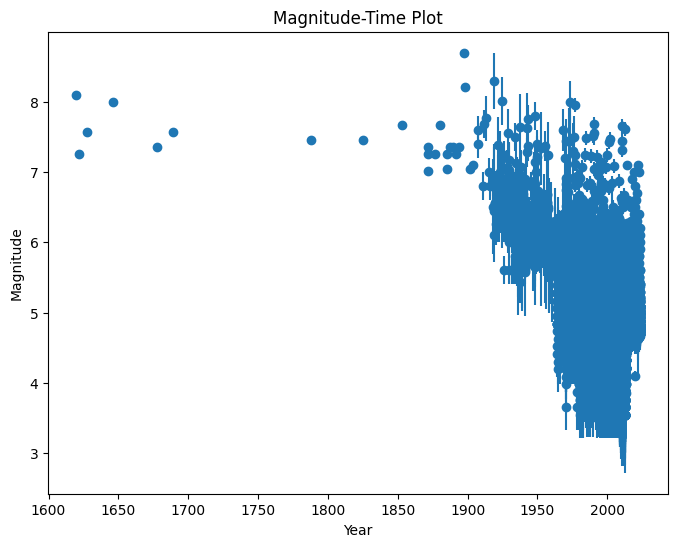

In [5]:
plot_magnitude_time_scatter(catalogue, plot_error=True)

Or, more informatively, plot the density of events with time

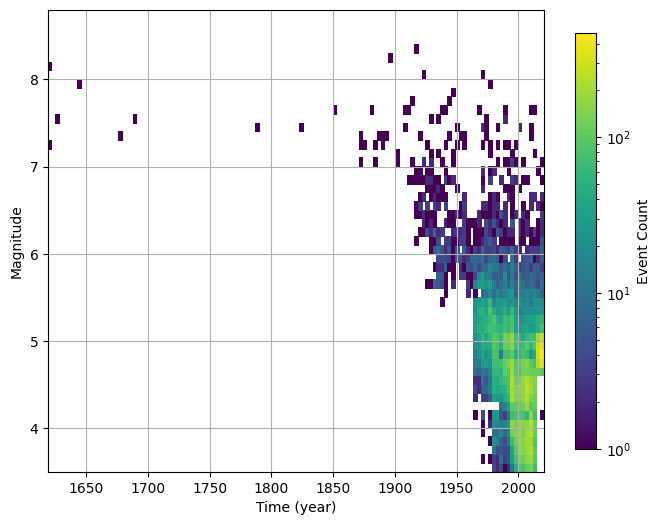

In [6]:
magnitude_bin_width = 0.1  # In magnitude units
time_bin_width = 3.0 # In years
plot_magnitude_time_density(catalogue, magnitude_bin_width, time_bin_width)

### View the Depth Distribution

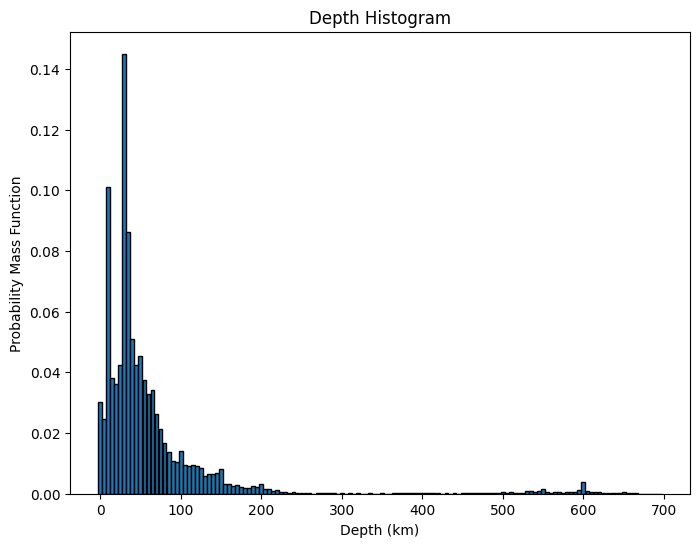

In [7]:
# Shows depth histogram every 5 km  
plot_depth_histogram(catalogue, 5., normalisation=True)

### Mapping the Catalogue

We can map the catalogue using the HMTK's mapping functions. A 'basemap' can support multiple layers:

In [8]:
# Map configuration
llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i', 
              'title': "Earthquake Catalogue"}

In [9]:
from openquake.plt.mapping import HMTKBaseMap

In [10]:
# Creating a basemap - input a configuration and (if desired) a title
basemap1 = HMTKBaseMap(map_config)

# Adding the catalogue to the basemap
# In this case we will 'close' the figure after rendering, we do this by setting 'overlay=False'
# This is also the default option
# If we wanted to add another layer on top, we would set the overlay to True
basemap1.add_catalogue(catalogue)
basemap1.savemap('raw_catalogue.png')

Map saved to gmt/raw_catalogue.png.


### Declustering

The HMTK supports several methods for declustering the earthquake catalogue:

1. Gardner & Knopoff (1974)

2. AFTERAN (Musson, 1999)

Others will (eventually) be added in the future

We illustrate the use of the Gardner & Knopoff Algorithm

#### Configuring the algorithm

In [11]:
# Create an `instance' of the tool
declust_method = GardnerKnopoffType1()

# Create a configuration file
declust_config = {"time_distance_window": GardnerKnopoffWindow(), "fs_time_prop": 1.0}

### Running the algorithm

All declustering algorithms produce two outputs:

* cluster_index = Vector indicating the number of the cluster to which the earthquake belongs (including mainshock)
* cluster_flag = Vector indicating if the event is a foreshock (-1), mainshock (0) or aftershock (1)

In [12]:
cluster_index, cluster_flag = declust_method.decluster(catalogue, declust_config)

data = np.column_stack([catalogue.get_decimal_time(),
                        catalogue.data['magnitude'],
                        catalogue.data['longitude'],
                        catalogue.data['latitude'], cluster_index, cluster_flag])
print('      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)')
for row in data:
    print('%14.8f  %6.2f  %8.3f  %8.3f  %6.0f  %6.0f' %(row[0], row[1], row[2], row[3], row[4], row[5]))

      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)
 1619.91278539    8.10   121.600    18.170       0       0
 1621.91643836    7.25   122.100    11.700       0       0
 1627.66712329    7.57   121.800    18.700       0       0
 1645.91369863    7.99   121.200    15.600       0       0
 1677.93287671    7.36   119.500    14.500       0       0
 1688.79918033    7.57   122.200    16.950       0       0
 1787.52862443    7.46   122.250    11.050       0       0
 1824.81830601    7.46   121.900    14.200       0       0
 1852.70884563    7.68   120.400    13.950       0       0
 1871.84520548    7.36   126.900     8.900      22       0
 1871.93561644    7.02   123.750     7.300       0       0
 1871.96575342    7.25   126.900     8.500      22       1
 1876.56420765    7.25   126.400    10.100       0       0
 1880.54424712    7.68   121.850    16.000       0       0
 1885.14383562    7.25   127.100     7.900       0       0
 1885

### Purging non-Poissonian Events from the Catalogue

Having run the declustering algorithm you may want to remove all of the 'non-Poissonian' events (i.e. foreshocks and aftershocks) from the catalogue

In [13]:
# Copying the catalogue and saving it under a new name "catalogue_dec"(declustered catalogue) 
catalogue_dec = deepcopy(catalogue)

# Logical indexing: Choosing the outputs for the main events: Cluster_flag = 0 
mainshock_flag = cluster_flag == 0 

# Filtering the foreshocks and aftershocks in the copy of the catalogue 
catalogue_dec.purge_catalogue(mainshock_flag)


# Printing the number of events considered main shocks
print('Declustering: ok')
print("Number of events in original catalogue: %g" % catalogue.get_number_events())
print('Number of mainshocks: %g' % catalogue_dec.get_number_events())

Declustering: ok
Number of events in original catalogue: 26487
Number of mainshocks: 6442


In [ ]:
map_config['title'] = 'Declustered Earthquake Catalogue'
basemap2 = HMTKBaseMap(map_config)
basemap2.add_catalogue(catalogue_dec, overlay=False)

### Saving the catalogue

In [15]:
# Selecting path and name for the output file 
output_dir = r'C:\Users\AMH-L91\OneDrive - AMH Philippines, Inc\NP23.067 GHD Libmanan Wind Farm SHA\06 NP23.067 WORK FILES\06 SHA\03 Output Files'
output_cat_dec = os.path.join(output_dir, 'Overall_Seismicity_Dec_2023.05.15.csv')

if os.path.exists(output_cat_dec):
    os.remove(output_cat_dec)

# Call the method and save the output file under the name "cat_csv"
cat_csv = CsvCatalogueWriter(output_cat_dec) 

# Write the purged catalogue
cat_csv.write_file(catalogue_dec)
print("Catalogue successfully written to %s" % output_cat_dec)

Catalogue successfully written to C:\Users\AMH-L91\OneDrive - AMH Philippines, Inc\NP23.067 GHD Libmanan Wind Farm SHA\06 NP23.067 WORK FILES\06 SHA\03 Output Files\Overall_Seismicity_Dec_2023.05.15.csv


In [16]:
catalogue_dec_shallow = deepcopy(catalogue_dec)
catalogue_dec_shallow.purge_catalogue(catalogue_dec.data['depth'] <= 50.)
catalogue_dec_mid = deepcopy(catalogue_dec)
catalogue_dec_mid.purge_catalogue(np.all([catalogue_dec.data['depth'] > 50., catalogue_dec.data['depth'] <= 100.], axis=0))
catalogue_dec_deep = deepcopy(catalogue_dec)
catalogue_dec_deep.purge_catalogue(catalogue_dec.data['depth'] > 100.)
    
output_cat_dec_shallow = os.path.join(output_dir, 'Overall_Seismicity_Dec_Shallow_2023.05.15.csv')
output_cat_dec_mid = os.path.join(output_dir, 'Overall_Seismicity_Dec_MidCrust_2023.05.15.csv')
output_cat_dec_deep = os.path.join(output_dir, 'Overall_Seismicity_Dec_Deep_2023.05.15.csv')

cat_shallow_csv = CsvCatalogueWriter(output_cat_dec_shallow)
cat_mid_csv = CsvCatalogueWriter(output_cat_dec_mid)
cat_deep_csv = CsvCatalogueWriter(output_cat_dec_deep)

cat_shallow_csv.write_file(catalogue_dec_shallow)
print("Number of shallow earthquakes in declustered catalogue: %g" % catalogue_dec_shallow.get_number_events())
print("Catalogue successfully written to %s" % output_cat_dec_shallow)
cat_mid_csv.write_file(catalogue_dec_mid)
print("Number of mid-crust earthquakes in declustered catalogue: %g" % catalogue_dec_mid.get_number_events())
print("Catalogue successfully written to %s" % output_cat_dec_mid)
cat_deep_csv.write_file(catalogue_dec_deep)
print("Number of deep earthquakes in declustered catalogue: %g" % catalogue_dec_deep.get_number_events())
print("Catalogue successfully written to %s" % output_cat_dec_deep)

Number of shallow earthquakes in declustered catalogue: 4189
Catalogue successfully written to C:\Users\AMH-L91\OneDrive - AMH Philippines, Inc\NP23.067 GHD Libmanan Wind Farm SHA\06 NP23.067 WORK FILES\06 SHA\03 Output Files\Overall_Seismicity_Dec_Shallow_2023.05.15.csv
Number of mid-crust earthquakes in declustered catalogue: 1344
Catalogue successfully written to C:\Users\AMH-L91\OneDrive - AMH Philippines, Inc\NP23.067 GHD Libmanan Wind Farm SHA\06 NP23.067 WORK FILES\06 SHA\03 Output Files\Overall_Seismicity_Dec_MidCrust_2023.05.15.csv
Number of deep earthquakes in declustered catalogue: 909
Catalogue successfully written to C:\Users\AMH-L91\OneDrive - AMH Philippines, Inc\NP23.067 GHD Libmanan Wind Farm SHA\06 NP23.067 WORK FILES\06 SHA\03 Output Files\Overall_Seismicity_Dec_Deep_2023.05.15.csv


### Analysis of Completeness

Completeness: ok


Completeness table using Stepp method (1971)
[[1954.     3.5]
 [1954.     4. ]
 [1954.     4.5]
 [1954.     5. ]
 [1945.     5.5]
 [1929.     6. ]
 [1894.     6.5]
 [1886.     7. ]
 [1873.     7.5]
 [1830.     8. ]]




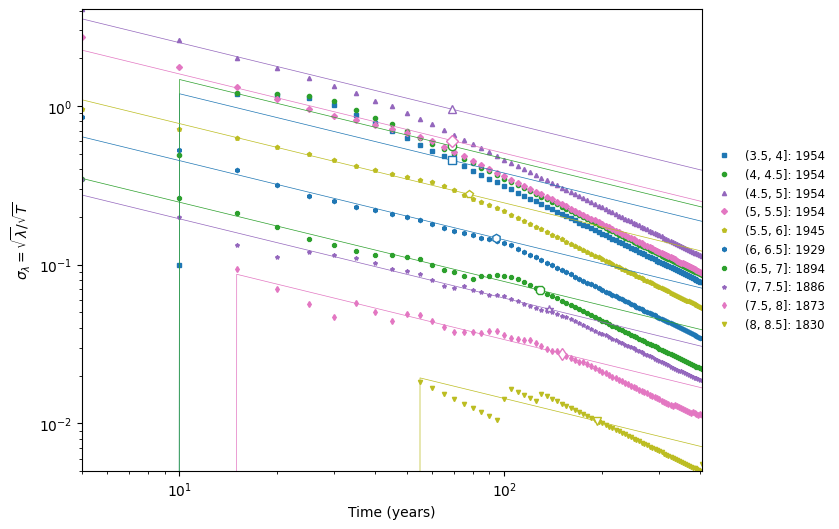

In [17]:
# Set up the configuration parameters
comp_config = {'magnitude_bin': 0.5, 'time_bin': 5.0, 'increment_lock': True}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(catalogue_dec, comp_config)
print('Completeness: ok')

# Print the completeness table
print('\n')
print('Completeness table using Stepp method (1971)')
print(completeness_table)
print('\n')

# Setting configuration for the completeness plot
completeness_parameters = completeness_algorithm
output_file = os.path.join(output_dir, "Project_Completeness_Overall_Plot.png")
if os.path.exists(output_file):
    os.remove(output_file)
# plot_stepp_1972.create_stepp_plot(completeness_parameters, output_file)
plot_stepp_1972.create_stepp_plot(completeness_parameters, figure_size=(8, 6), 
                                  filename=output_file, filetype='png', dpi=300, ax=None)

### Manual setup of the completeness table

The hmtk allows to use a completeness table proposed by the modeller. 

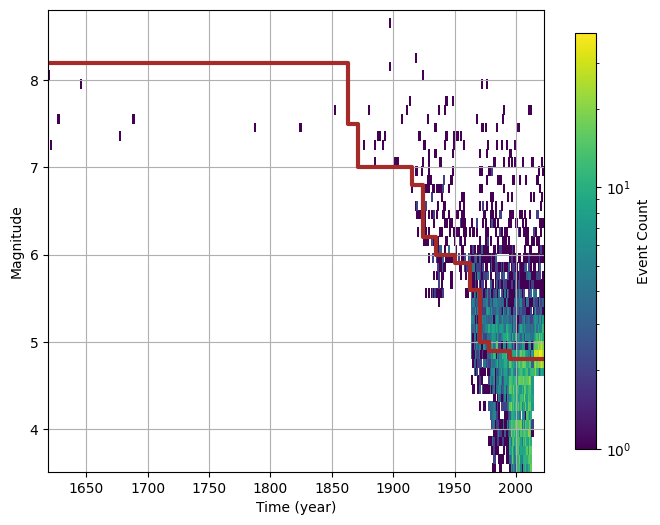

In [18]:
# Table format (GLOBAL)


completeness_table_a = np.array([[1995., 4.8],
                                 [1978., 4.9],
                                 [1971., 5.0],
                                 [1963., 5.6],
                                 [1950., 5.9],
                                 [1935., 6.0],
                                 [1924., 6.2],
                                 [1915., 6.8],
                                 [1871., 7.0],
                                 [1863., 7.5],
                                 [1619., 8.2]])

plot_magnitude_time_density(catalogue_dec, 0.1, 1.0,
                            completeness=completeness_table_a, figure_size=(8, 6), 
                                  filename=os.path.join(output_dir, "global_Stepp_plot"), filetype='png', dpi=300, ax=None)

# Estimating Recurrence

Several methods are available for estimating recurrence taking into account time-dependent completeness

1. 'Weighted' Maximum Likelihood
2. Kijko & Smit (2012)
3. Weichert (1980)
4. Penalized Maximum Likelihood (Johnston et al., 1994)

In [19]:
recurrence_estimator = Weichert()

recurrence_config = {"magnitude_interval": 0.1, "reference_magnitude": None}

bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(catalogue_dec,
                                                              recurrence_config,
                                                              completeness_table_a)

print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))

a = 6.546 (+/- 0.008),  b = 1.005 (+/-0.015)


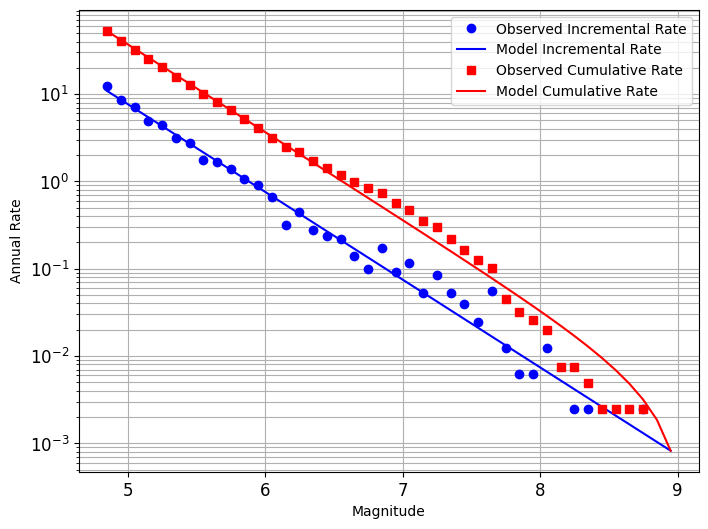

In [20]:
mfd0 = TruncatedGRMFD(4.8, 9., 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1, figure_size=(8, 6), 
                                  filename=os.path.join(output_dir, "plot overall recurrence"), filetype='png', dpi=300, ax=None)